In [1]:
from datetime import timedelta, date
import os
import gc

#warning ignore future
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
gc.collect()

import numpy as np
import random as rn
import tensorflow as tf
import keras
from keras import backend as K

#-----------------------------Keras reproducible------------------#
#COmpatible con python 3.6   no con 3.7
#instalar primero keras 2.2.4
# luego tensorflow 1.9

SEED = 29082013
try:
    tf.random.set_seed(SEED)
except:
    tf.set_random_seed(SEED)
    
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.Session(
    graph=tf.get_default_graph(), 
    config=session_conf
)
K.set_session(sess)
#-----------------------------------------------------------------#

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam


tf.__version__, keras.__version__

Using TensorFlow backend.


('1.9.0', '2.2.4')

In [2]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days) + 1):
        yield date1 + timedelta(n)
        
start_dt = date(2015, 12, 20)
end_dt = date(2016, 1, 11)
for dt in daterange(start_dt, end_dt):
    print(dt.strftime("%Y-%m-%d"))

2015-12-20
2015-12-21
2015-12-22
2015-12-23
2015-12-24
2015-12-25
2015-12-26
2015-12-27
2015-12-28
2015-12-29
2015-12-30
2015-12-31
2016-01-01
2016-01-02
2016-01-03
2016-01-04
2016-01-05
2016-01-06
2016-01-07
2016-01-08
2016-01-09
2016-01-10
2016-01-11


### Load data

In [3]:
dataset = pd.read_csv(
    'AAPL_2006-01-01_to_2018-01-01.csv', 
    parse_dates=['Date']
).sort_values(
    by=['Date'], ascending=True
)

display(dataset.head(1))
display(dataset.tail(1))

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL


,Date,Open,High,Low,Close,Volume,Name
3018,2017-12-29,170.52,170.59,169.22,169.23,25999922,AAPL


### DETECCION DE DIAS SIN DATOS

In [4]:
start_dt = date(2006, 1, 3)
end_dt = date(2017, 12, 29)

list_complete_date = [
    (start_dt + timedelta(n)).strftime("%Y-%m-%d") for n in range(int ((end_dt - start_dt).days) + 1)
]

(end_dt - start_dt).days, dataset.shape, len(list_complete_date)

(4378, (3019, 7), 4379)

In [5]:
df_date = pd.DataFrame(list_complete_date)
df_date.columns = ['Date']
df_date['Date'] = pd.to_datetime(df_date['Date'])
df_date['year'] = df_date['Date'].dt.year
df_date['month'] = df_date['Date'].dt.month
df_date['weekday'] = df_date['Date'].dt.weekday
df_date['week'] = df_date['Date'].dt.week

dataset = df_date.merge(dataset, on='Date', how='left')

display(dataset.head(7))
display(dataset.tail(7))

,Date,year,month,weekday,week,Open,High,Low,Close,Volume,Name
0,2006-01-03,2006,1,1,1,10.34,10.68,10.32,10.68,201853036.0,AAPL
1,2006-01-04,2006,1,2,1,10.73,10.85,10.64,10.71,155225609.0,AAPL
2,2006-01-05,2006,1,3,1,10.69,10.70,10.54,10.63,112396081.0,AAPL
3,2006-01-06,2006,1,4,1,10.75,10.96,10.65,10.90,176139334.0,AAPL
4,2006-01-07,2006,1,5,1,NaN,NaN,NaN,NaN,NaN,NaN
5,2006-01-08,2006,1,6,1,NaN,NaN,NaN,NaN,NaN,NaN
6,2006-01-09,2006,1,0,2,10.96,11.03,10.82,10.86,168861224.0,AAPL


,Date,year,month,weekday,week,Open,High,Low,Close,Volume,Name
4372,2017-12-23,2017,12,5,51,NaN,NaN,NaN,NaN,NaN,NaN
4373,2017-12-24,2017,12,6,51,NaN,NaN,NaN,NaN,NaN,NaN
4374,2017-12-25,2017,12,0,52,NaN,NaN,NaN,NaN,NaN,NaN
4375,2017-12-26,2017,12,1,52,170.80,171.47,169.68,170.57,33185536.0,AAPL
4376,2017-12-27,2017,12,2,52,170.10,170.78,169.71,170.60,21498213.0,AAPL
4377,2017-12-28,2017,12,3,52,171.00,171.85,170.48,171.08,16480187.0,AAPL
4378,2017-12-29,2017,12,4,52,170.52,170.59,169.22,169.23,25999922.0,AAPL


In [6]:
inputation_key = ['year', 'month']

df = dataset.merge(
    dataset.groupby(
        by=inputation_key
    )['High'].median().reset_index().rename(
        columns={'High':'High_month_median'}
    ),
    on=inputation_key,
    how='left'
)
df['High'] = df['High'].combine_first(df['High_month_median'])
df = df.set_index('Date')
dataset = df.copy()

dataset.head(25)

,year,month,weekday,week,Open,High,Low,Close,Volume,Name,High_month_median
Date,,,,,,,,,,,
2006-01-03,2006,1,1,1,10.34,10.68,10.32,10.68,201853036.0,AAPL,11.21
2006-01-04,2006,1,2,1,10.73,10.85,10.64,10.71,155225609.0,AAPL,11.21
2006-01-05,2006,1,3,1,10.69,10.70,10.54,10.63,112396081.0,AAPL,11.21
2006-01-06,2006,1,4,1,10.75,10.96,10.65,10.90,176139334.0,AAPL,11.21
2006-01-07,2006,1,5,1,NaN,11.21,NaN,NaN,NaN,NaN,11.21
2006-01-08,2006,1,6,1,NaN,11.21,NaN,NaN,NaN,NaN,11.21
2006-01-09,2006,1,0,2,10.96,11.03,10.82,10.86,168861224.0,AAPL,11.21
2006-01-10,2006,1,1,2,10.89,11.70,10.83,11.55,570088246.0,AAPL,11.21
2006-01-11,2006,1,2,2,11.98,12.11,11.80,11.99,373548882.0,AAPL,11.21


In [7]:
dataset.index.min(), dataset.index.max(), dataset.shape

(Timestamp('2006-01-03 00:00:00'),
 Timestamp('2017-12-29 00:00:00'),
 (4379, 11))

In [8]:
set_entrenamiento = dataset['2006-01':'2017-06'].iloc[:, 5:6]
set_validacion = dataset['2017-07':'2017-08'].iloc[:, 5:6]

print(
    set_entrenamiento.index.min(), 
    set_entrenamiento.index.max(), 
    set_entrenamiento.shape
)
print(
    set_validacion.index.min(), 
    set_validacion.index.max(), 
    set_validacion.shape
)

2006-01-03 00:00:00 2017-06-30 00:00:00 (4197, 1)
2017-07-01 00:00:00 2017-08-31 00:00:00 (62, 1)


In [9]:
set_validacion.shape, set_entrenamiento.shape

((62, 1), (4197, 1))

In [10]:
display(set_entrenamiento.head(1))
display(set_entrenamiento.tail(1))
display(set_validacion.head(1))
display(set_validacion.tail(1))

,High
Date,
2006-01-03,10.68


,High
Date,
2017-06-30,144.96


,High
Date,
2017-07-01,150.18


,High
Date,
2017-08-31,164.52


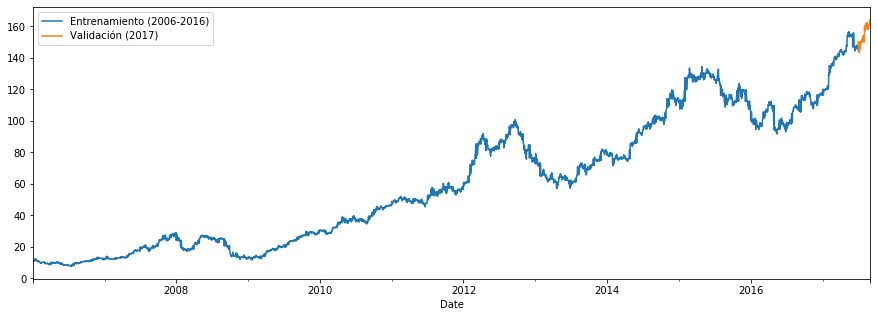

In [11]:
set_entrenamiento['High'].plot(legend=True, figsize=(15, 5))
set_validacion['High'].plot(legend=True)

plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

In [12]:
time_step = 7
set_entrenamiento[-1*time_step:].shape

(7, 1)

In [13]:
real_test = set_entrenamiento[-1*time_step:]

display(real_test['High'].head(2))
display(real_test['High'].tail(2))

Date
2017-06-24    147.015
2017-06-25    147.015
Name: High, dtype: float64

Date
2017-06-29    145.13
2017-06-30    144.96
Name: High, dtype: float64

## Modeling

In [14]:
# Normalización del set de entrenamiento

sc = MinMaxScaler(
    feature_range=(0, 1)
)
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
#set_entrenamiento_escalado = set_entrenamiento.copy().values
set_entrenamiento_escalado.shape

(4197, 1)

In [15]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [16]:
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step, m):
    X_train.append(
        set_entrenamiento_escalado[i - time_step: i, 0]
    )
    Y_train.append(
        set_entrenamiento_escalado[i, 0]
    )
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [17]:
X_train.shape, Y_train.shape

((4190, 7), (4190,))

In [18]:
display(X_train[0])

array([0.02092696, 0.02206721, 0.0210611 , 0.02280502, 0.02448186,
       0.02448186, 0.02327453])

In [19]:
X_train = np.reshape(
    X_train, 
    (X_train.shape[0], X_train.shape[1], 1)
)

display(X_train[0])

array([[0.02092696],
       [0.02206721],
       [0.0210611 ],
       [0.02280502],
       [0.02448186],
       [0.02448186],
       [0.02327453]])

In [20]:
# Red LSTM
#
dim_entrada = (X_train.shape[1], 1)
dim_salida = 1
epochs = 10
na = 200
batch_size = 32
lr = 0.0001

In [21]:
#help(Bidirectional)

In [22]:
#help(LSTM)

In [23]:
modelo = Sequential()
modelo.add(
    Bidirectional(LSTM(units=na,  activation='relu', return_sequences=True, input_shape=dim_entrada))
)
modelo.add(
    Bidirectional(LSTM(units=na, activation='relu'))
)
modelo.add(
    Dense(units=dim_salida)
)
modelo.compile(
    optimizer=Adam(lr=lr),
    loss='mse'
)
modelo.fit(
    X_train, 
    Y_train, 
    epochs=epochs, 
    batch_size=batch_size
)

Epoch 1/10
4190/4190 [==============================] - 27s 6ms/step - loss: 0.0459
Epoch 2/10
4190/4190 [==============================] - 24s 6ms/step - loss: 1.2615e-04
Epoch 3/10
4190/4190 [==============================] - 25s 6ms/step - loss: 1.2285e-04
Epoch 4/10
4190/4190 [==============================] - 27s 6ms/step - loss: 1.2212e-04
Epoch 5/10
4190/4190 [==============================] - 29s 7ms/step - loss: 1.2019e-04
Epoch 6/10
4190/4190 [==============================] - 25s 6ms/step - loss: 1.2107e-04
Epoch 7/10
4190/4190 [==============================] - 24s 6ms/step - loss: 1.2141e-04
Epoch 8/10
4190/4190 [==============================] - 24s 6ms/step - loss: 1.2121e-04
Epoch 9/10
4190/4190 [==============================] - 23s 6ms/step - loss: 1.2350e-04
Epoch 10/10
4190/4190 [==============================] - 23s 5ms/step - loss: 1.1954e-04


In [24]:
set_validacion.shape, real_test.shape

((62, 1), (7, 1))

In [25]:
#
# Validación (predicción del valor de las acciones)
#
x_test = real_test.values
x_test = sc.transform(x_test)
x_test.shape

(7, 1)

In [26]:
x_test.shape, x_test[-1*time_step:].shape

((7, 1), (7, 1))

In [27]:
x_test.shape

(7, 1)

In [28]:
nn = set_validacion.shape[0]
index_validacion = set_validacion.index.copy()
_x_test = x_test.copy()
list_forecast = []

for i in range(nn):
    test_predict = np.array(
        [_x_test[-1*time_step:]]
    )
    
    test_predict = np.reshape(
        test_predict, (test_predict.shape[0], test_predict.shape[1], 1)
    )

    prediccion = modelo.predict(test_predict)

    _x_test = np.append(_x_test, prediccion, axis=0)

    list_forecast.append(sc.inverse_transform(prediccion)[0][0])
    #list_forecast.append(prediccion[0][0])

In [29]:
x_test.shape, _x_test.shape, len(list_forecast)

((7, 1), (69, 1), 62)

In [30]:
serie_result = pd.Series(list_forecast, index=index_validacion)
serie_result.head(200)

Date
2017-07-01    147.099365
2017-07-02    147.068542
2017-07-03    147.077927
2017-07-04    146.947006
2017-07-05    147.079132
2017-07-06    147.245178
2017-07-07    147.556396
2017-07-08    147.914200
2017-07-09    148.038437
2017-07-10    148.191147
2017-07-11    148.365616
2017-07-12    148.580444
2017-07-13    148.806030
2017-07-14    149.038162
2017-07-15    149.259201
2017-07-16    149.463638
2017-07-17    149.680130
2017-07-18    149.905548
2017-07-19    150.137985
2017-07-20    150.373032
2017-07-21    150.609650
2017-07-22    150.847488
2017-07-23    151.088272
2017-07-24    151.334534
2017-07-25    151.585251
2017-07-26    151.839859
2017-07-27    152.097977
2017-07-28    152.359802
2017-07-29    152.625641
2017-07-30    152.895889
2017-07-31    153.170715
2017-08-01    153.450058
2017-08-02    153.733887
2017-08-03    154.022369
2017-08-04    154.315659
2017-08-05    154.613953
2017-08-06    154.917343
2017-08-07    155.225998
2017-08-08    155.540039
2017-08-09    155.85

In [31]:
set_validacion['High'].head(25)

Date
2017-07-01    150.18
2017-07-02    150.18
2017-07-03    145.30
2017-07-04    150.18
2017-07-05    144.79
2017-07-06    143.50
2017-07-07    144.75
2017-07-08    150.18
2017-07-09    150.18
2017-07-10    145.95
2017-07-11    145.85
2017-07-12    146.18
2017-07-13    148.49
2017-07-14    149.33
2017-07-15    150.18
2017-07-16    150.18
2017-07-17    150.90
2017-07-18    150.13
2017-07-19    151.42
2017-07-20    151.74
2017-07-21    150.44
2017-07-22    150.18
2017-07-23    150.18
2017-07-24    152.44
2017-07-25    153.84
Name: High, dtype: float64

In [32]:
from sklearn.metrics import mean_squared_error

mean_squared_error(
    set_validacion['High'], serie_result
)

7.416682862144787

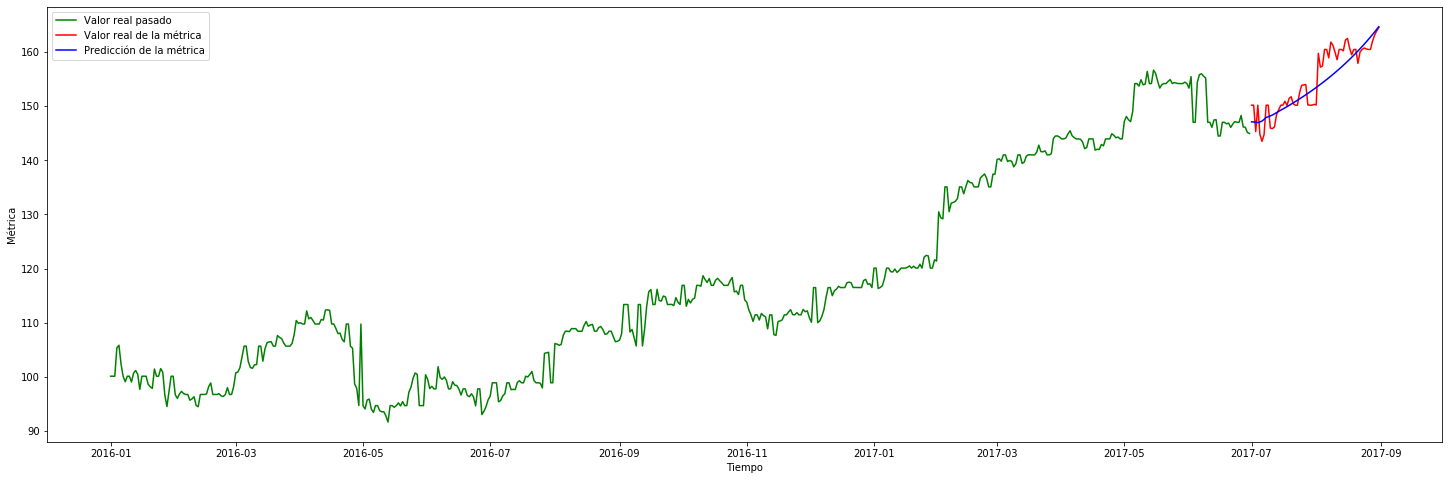

In [33]:
# Graficar resultados
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 8))

axes.plot(set_entrenamiento['2016':]['High'], color='green', label='Valor real pasado')
plt.plot(set_validacion['High'], color='red', label='Valor real de la métrica')
plt.plot(serie_result, color='blue', label='Predicción de la métrica')


#axes.axvline(set_entrenamiento.index[1698], color="blue", linestyle="--", lw=2)
#axes.axvline(set_entrenamiento.index[2300], color="blue", linestyle="--", lw=2)

#axes.axvline(set_validacion_init.index[160], color="blue", linestyle="--", lw=2)
#axes.axvline(set_validacion_init.index[230], color="blue", linestyle="--", lw=2)
#axes.axvline(set_validacion_init.index[240], color="blue", linestyle="--", lw=2)

#plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))

plt.xlabel('Tiempo')
plt.ylabel('Métrica')
plt.legend()
plt.show()